<a href="https://colab.research.google.com/github/sharanya-sharma/BurnoutPredict/blob/main/BurnoutPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import shap
from sklearn.preprocessing import LabelEncoder

In [5]:
# Load Dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
# Data Preprocessing
train.dropna(inplace=True)
test.dropna(inplace=True)

In [7]:
train.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52
5,fffe3300350037003500,2008-11-26,Male,Product,Yes,2.0,4.0,3.6,0.29


In [8]:
test.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score
0,fffe31003300390039003000,2008-12-10,Female,Service,No,2.0,5.0,7.7
1,fffe31003300310037003800,2008-08-14,Female,Product,Yes,1.0,2.0,5.2
2,fffe33003400380035003900,2008-11-13,Male,Product,Yes,1.0,3.0,5.9
3,fffe3100370039003200,2008-02-07,Female,Service,No,3.0,6.0,4.6
4,fffe32003600390036003700,2008-07-17,Female,Product,No,2.0,5.0,6.4


In [9]:
# Ensure X and y have the same samples
df_cleaned = train.dropna()
X = df_cleaned.drop(columns=['Burn Rate'])  # Features
y = df_cleaned['Burn Rate']  # Target

In [10]:
# Convert y to categorical for classification
y = pd.cut(y, bins=[-np.inf, 0.5, np.inf], labels=[0, 1])  # Binary classification
y = y.astype(int)  # Ensure it's integer type

In [11]:
# Convert categorical variables to numeric using Label Encoding
categorical_cols = X.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col])

In [12]:
# Reset index to avoid alignment issues
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [13]:
# Handling Class Imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [14]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [15]:
# Model Training - Random Forest with Hyperparameter Tuning
param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [16]:
# Best Model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

In [17]:
# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
mcc = matthews_corrcoef(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [18]:
print("Random Forest Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Matthews Correlation Coefficient:", mcc)
print("Confusion Matrix:\n", conf_matrix)
print(classification_report(y_test, y_pred))

Random Forest Accuracy: 0.9533273782938811
Precision: 0.9533211774938755
Recall: 0.9533250662276163
F1 Score: 0.9533230743066241
Matthews Correlation Coefficient: 0.9066462437131522
Confusion Matrix:
 [[2113  104]
 [ 105 2156]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2217
           1       0.95      0.95      0.95      2261

    accuracy                           0.95      4478
   macro avg       0.95      0.95      0.95      4478
weighted avg       0.95      0.95      0.95      4478



<Figure size 640x480 with 0 Axes>

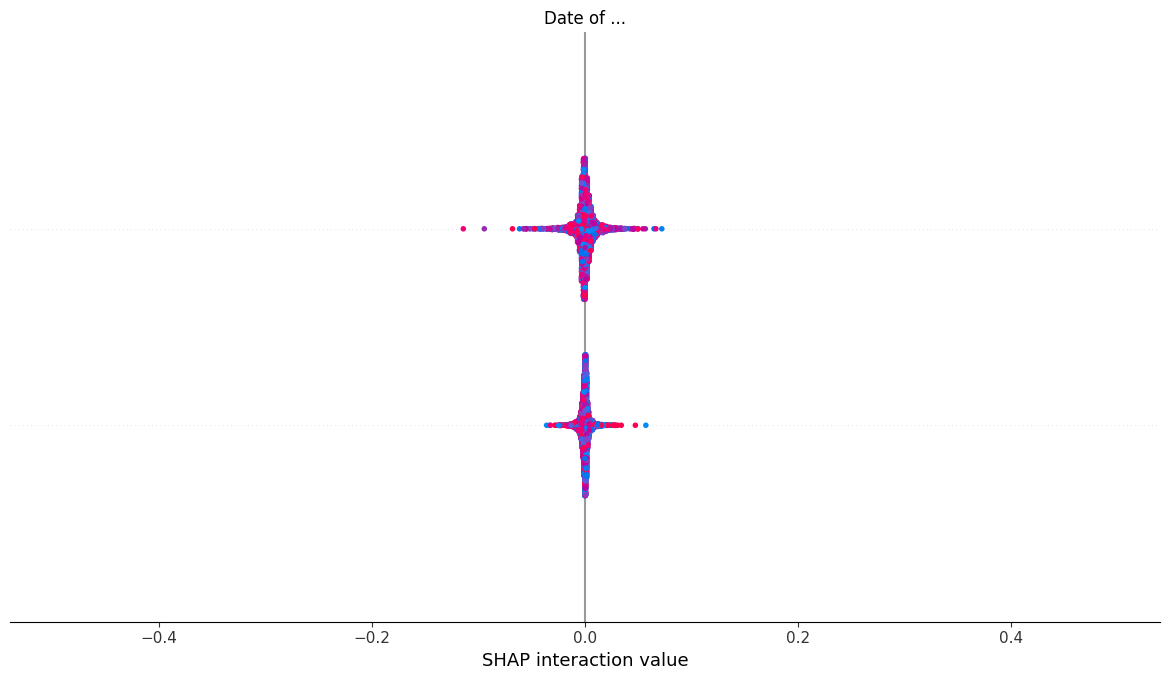

In [19]:
# SHAP for Explainability
explainer = shap.TreeExplainer(best_rf)  # Explicitly use TreeExplainer
shap_values = explainer.shap_values(X_test)  # Use .shap_values() instead of direct call
shap.summary_plot(shap_values, X_test)

Global Feature Importance (Summary Plot)

<Figure size 640x480 with 0 Axes>

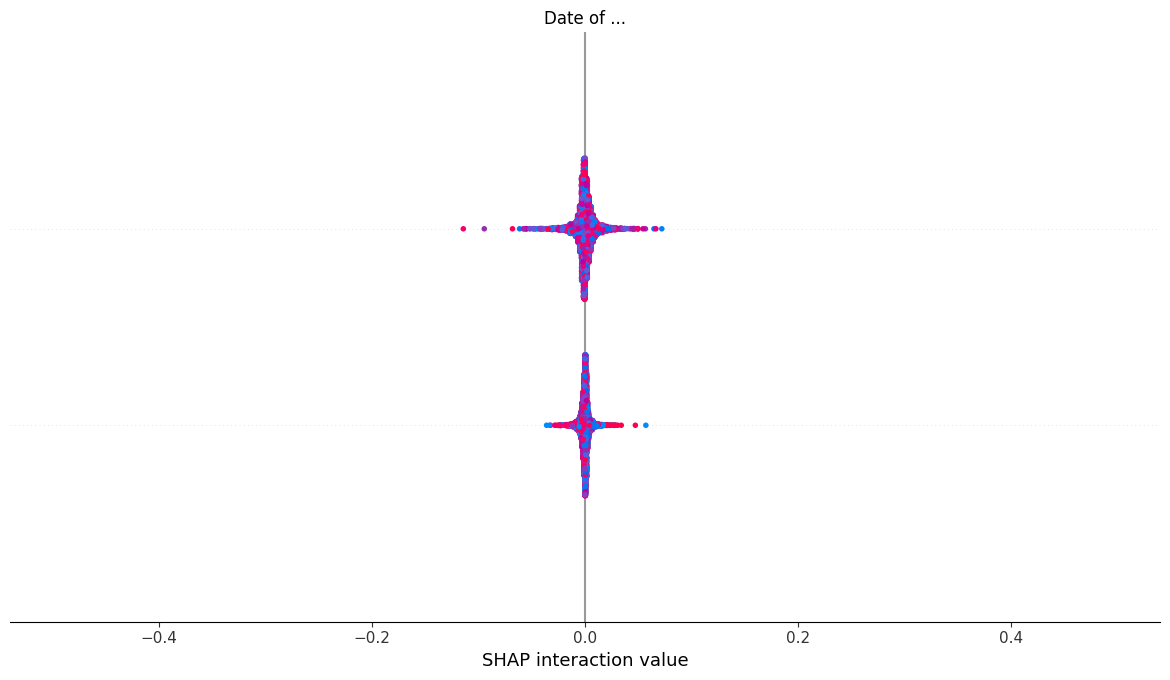

In [20]:
shap.summary_plot(shap_values, X_test)

Confusion Matrix Visualization

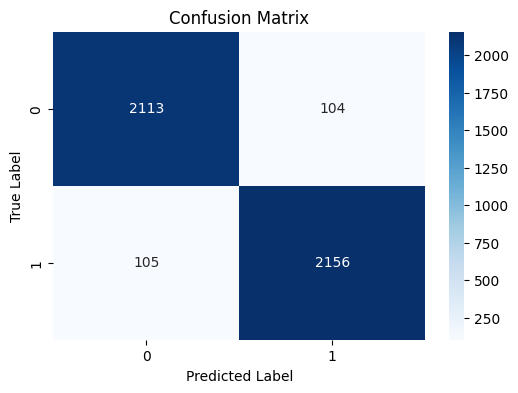

In [21]:
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Feature Importance (Random Forest)

<ipython-input-23-5829621a890b>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='viridis')


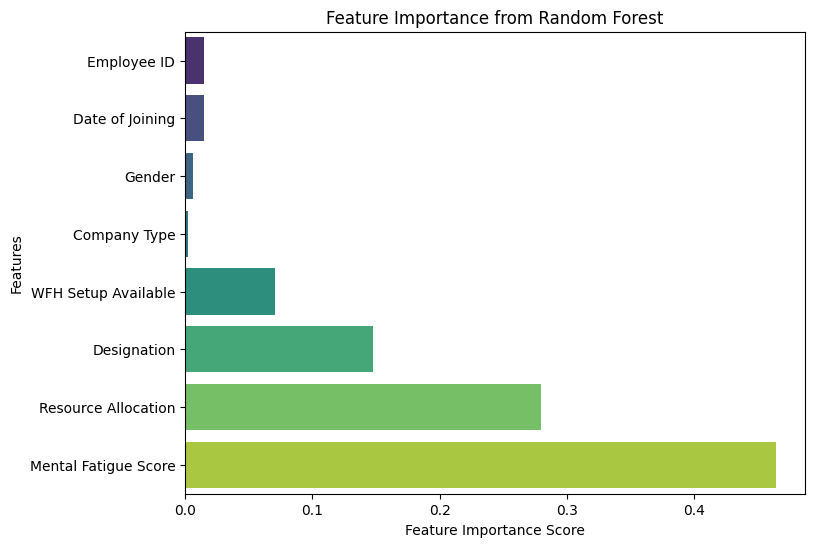

In [23]:
importances = best_rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8,6))
sns.barplot(x=importances, y=feature_names, palette='viridis')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')
plt.show()

ROC Curve for Performance Analysis

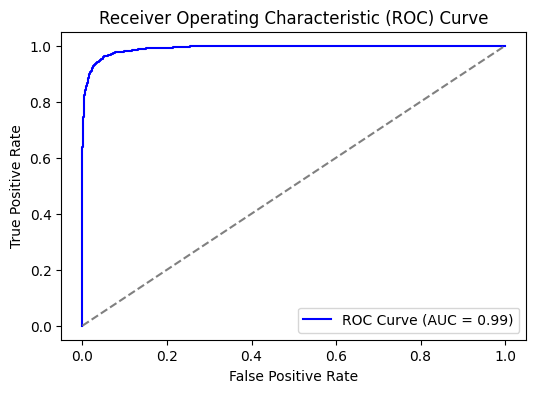

In [26]:
y_prob = best_rf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

 Gender vs. Burnout Classification

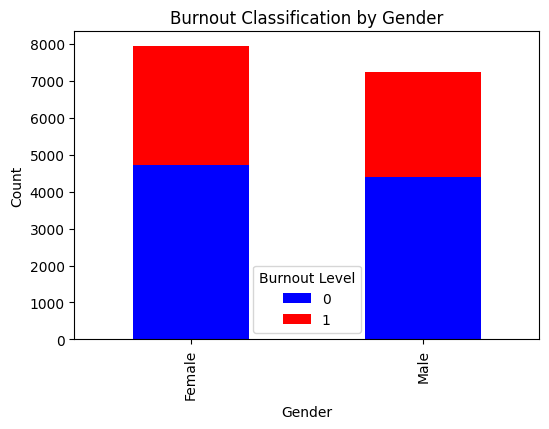

In [27]:
gender_classification = pd.crosstab(train['Gender'], y)
gender_classification.plot(kind='bar', stacked=True, color=['blue', 'red'], figsize=(6,4))
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Burnout Classification by Gender')
plt.legend(title='Burnout Level')
plt.show()

In [22]:
# Dummy Input for Model Check
dummy_input = X_test.iloc[[0]]  # Keep it as a DataFrame instead of converting to a NumPy array
dummy_pred = best_rf.predict(dummy_input)
print("Dummy Input Prediction:", dummy_pred)
print("Actual Label:", y_test.iloc[0])

Dummy Input Prediction: [1]
Actual Label: 1
